quiero comprobar que el metodo lasso elimina los terminos de grados mayores a 1 en el caso de un origen lineal

- how many times the coefficients are in the correct direction?
- hacer cluster de multico x2 = f(x3, x4)
- crear 1000 puntos de datos, y mostrar como cambian los coeff con muestras de 100.
- mostrar como cambia el p y el std err.
- Como evaluar la dependencia de variables estocasticas.
- como medir el efecto final en la variable objetivo debida a la variable que inicio la reacción.

__Conclusions__

The lower de noise in the x1 and x2 linear relation, the larger de oscilaton of parameters in the fit for
y, so, you can get oppositive parameters to the real ones. The last can happend with a good r_2 >= 0.7. The collineal effect can't be seen when noise==0.

Do plot of proportion of opposite sign vs noise.

In [23]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 30
# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2
# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

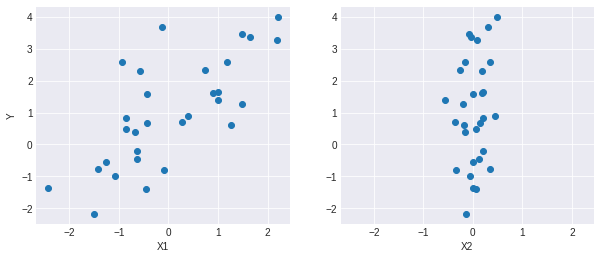

In [24]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

In [30]:
import statsmodels.api as sm
mu, sigma = 2, 0.9
X1 = np.random.normal(mu, sigma, size=100)
X2 = np.random.normal(loc=X1, scale=0.05)
Y = np.random.normal(loc=X1+X2, scale=1)
X = np.concatenate([X1.reshape(-1, 1), X2.reshape(-1, 1)], 1)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
#predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     223.3
Date:                Sun, 07 Jun 2020   Prob (F-statistic):           5.01e-37
Time:                        19:20:16   Log-Likelihood:                -132.97
No. Observations:                 100   AIC:                             271.9
Df Residuals:                      97   BIC:                             279.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0200      0.220     -0.091      0.9

In [72]:
basic_model = pm.Model()
with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
    # instantiate sampler
    #step = pm.Slice()
    # draw 5000 posterior samples
    trace = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [05:38<00:00, 65.03draws/s]
The acceptance probability does not match the target. It is 0.8876938881015637, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2b8173f50>,
      dtype=object)

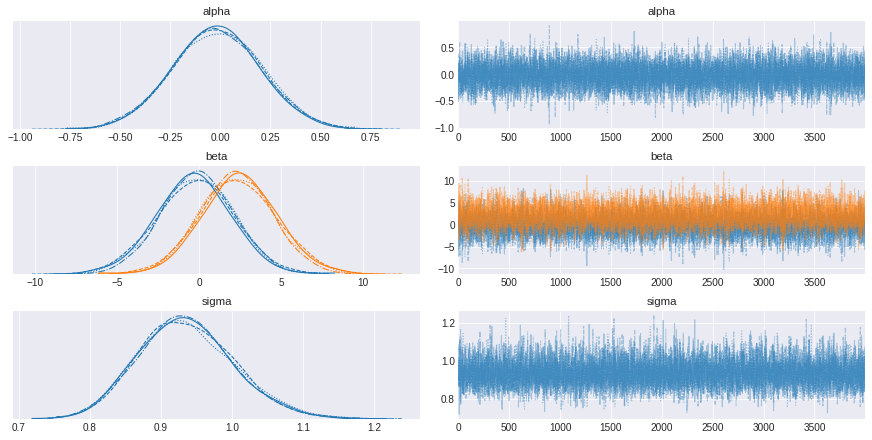

In [73]:
pm.traceplot(trace[1000:])

In [33]:
pm.summary(trace).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.02,0.22,-0.42,0.42,0.00,0.00,10888.0,6700.0,10898.0,8868.0,1.0
beta[0],-0.33,2.22,-4.44,3.90,0.03,0.02,7436.0,7362.0,7427.0,8907.0,1.0
beta[1],2.40,2.22,-1.82,6.52,0.03,0.02,7412.0,7412.0,7405.0,8988.0,1.0
sigma,0.94,0.07,0.81,1.07,0.00,0.00,10744.0,10636.0,10833.0,10217.0,1.0


In [62]:
def glm_mcmc_inference(df, iterations=5000):
    """
    Calculates the Markov Chain Monte Carlo trace of
    a Generalised Linear Model Bayesian linear regression 
    model on supplied data.

    df: DataFrame containing the data
    iterations: Number of iterations to carry out MCMC for
    """
    # Use PyMC3 to construct a model context
    basic_model = pm.Model()
    with basic_model:
        # Create the glm using the Patsy model syntax
        # We use a Normal distribution for the likelihood
        pm.GLM.from_formula("Y ~ X1 + X2", df)

        # Use Maximum A Posteriori (MAP) optimisation as initial value for MCMC
        start = pm.find_MAP()

        # Use the No-U-Turn Sampler
        step = pm.NUTS()

        # Calculate the trace
        trace = pm.sample(
            iterations, step, start, 
            random_seed=42, progressbar=True
        )

    return trace

In [63]:
import pandas as pd
df = pd.DataFrame()
df['Y'] = Y
df['X1'] = X1
df['X2'] = X2 

In [64]:
trace = glm_mcmc_inference(df, iterations=5000)

logp = -151.39, ||grad|| = 0.36083: 100%|██████████| 35/35 [00:00<00:00, 1537.57it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, X2, X1, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [04:50<00:00, 75.64draws/s] 
The acceptance probability does not match the target. It is 0.8824249573919438, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2a97482d0>,
      dtype=object)

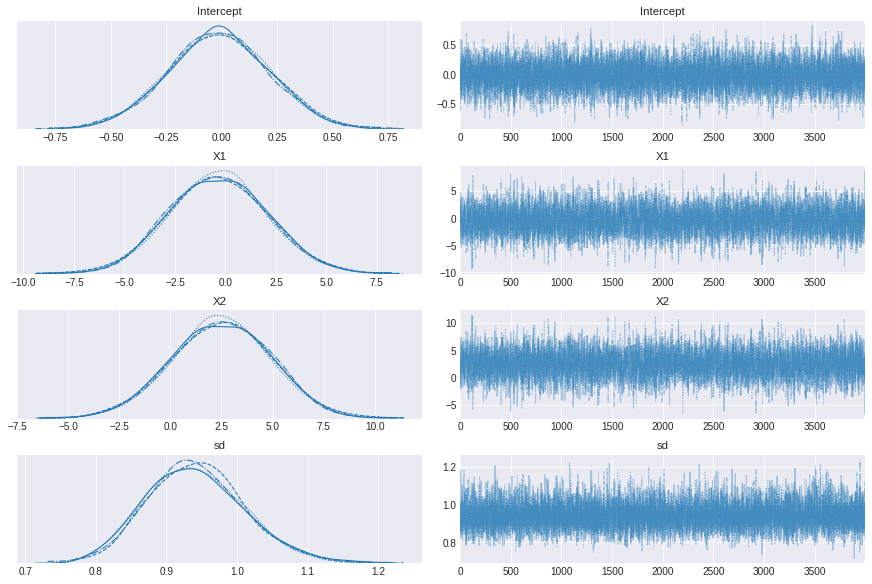

In [65]:
pm.traceplot(trace[1000:])

In [1]:
from sklearn import linear_model

In [2]:
bareg = linear_model.BayesianRidge()
lireg = linear_model.LinearRegression()

In [3]:
reg.fit(df.values[:, 1:], df.values[:, 0])
lireg.fit(df.values[:, 1:], df.values[:, 0])

NameError: name 'df' is not defined

In [86]:
reg.coef_

array([0.80923041, 1.25820039])

In [87]:
lireg.coef_

array([-0.43266424,  2.50474319])

https://www.bayespy.org/examples/regression.html

Try to implement normal-Gamma Prior in pymc3 

To meausre the independient effect of a explanatory variable we should keep the other static, while change tha variable. With multicollinearity we can't do that.

https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3/

https://juanitorduz.github.io/intro_pymc3/

https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb

https://iopscience.iop.org/article/10.1088/1742-6596/1265/1/012021/pdf

https://kieranrcampbell.github.io/blog/2016/05/15/gibbs-sampling-bayesian-linear-regression.html